In the previous notebook, we discussed an overview of what deep learning is and why you might want to use it for cognitive modeling. In the present notebook, we will review some acoustic aspects of speech and then construct a model of phoneme recognition that we will use to investigate the recognition of morphologically complex words and how the dscriminability of segments changes over time.

Please note that some simplifications are made for the purposes of the workshop.

1. **Phonemes here are being used in the engineering/speech recognition sense**, which is only semi-related to how phonemes are discussed and used in linguistics. Here, they are used to refer to acoustically similar segments of speech, such as that /s/ will be acoustically similar in many of the instances in which it is encountered. The motivation for using phonemes is that a wide variety of deep neural networks that work with speech are designed to recognize phonemes.

2. **We are not using any sort of holdout data for testing or validation of the model.** Best practices for deep learning modeling are to have some data held out to assess the model on items it hasn't seen. Given the timeframe we are working with, we will eschew validating the model that we are training against novel data. This is not unlike using statistical regression models for psycholinguistic experiments, either, where it is typical to use all of the collected data for analysis. Nevertheless, more serious experimentation should involve more evalution of the model.

3. **Some bits of code that are used for loading and formatting data will be placed inside a `Julia` script that is called from within this notebook.** The code is available for you to peruse in the GitHub repository that the present notebook is part of, but the code will not be discussed in detail during the course of this workshop. The code otherwise distracts from the purposes of setting up and interpreting a deep learning model.

# Speech acoustics

* The speech signal is a time-series acoustic signal
    * It unfolds linearly over time, meaning there is an inherent sequential order to segments of it
    * Previous sections of the signal can predict future sections
* We can analyze the speech signal as being composed of many different sound frequencies
    * E.g., /s/ contains a large amount of energy at around 6000 Hz
    * These frequencies are a large part of what the human perceptual system uses to interpret speech
    * Using these frequencies or some representation thereof in the neural network is thus well-motivated

# Speech features in deep learning

* Neural networks aren't trained with the entire frequency spectrum of speech as input data
    * It would take too much memory
    * There would be more numbers to crunch, so they would run slower
    * We know humans, who speech is targeted to, perceive frequencies in a more log scale than linear scale, and not all frequencies are necessarily important (e.g., certain resonant frequencies are crucial in vowels, while random noise is not)
* Instead, neural networks are trained with more compact representations of speech
* Historically, a set of features known as Mel frequency cepstral coefficients (MFCCs) have frequently been used, which we will also be using
    * They represent a transform on the frequency information
    * Usually calculate derivatives to represent their change over time in the features
    * Compact description of the speech signal
    * Mathematically related to audio compression algorithms such as MP3
* Other options that have been used are Mel filterbanks, linear predictive coding (LPC) coefficients, perceptual linear predcitive coding (PLPC) coefficients, and filterbanks the network is foced to learn
* MFCCs (and other features) are calculated over small segments of speech over time
    * Commonly, calculated to describe 25 ms windows of speech with 10 ms between each window
* The features have already been calculated for the present workshop, and the resultant data will be loaded in

Let's get the environment set up. Note that we're going to train the network for `5` epochs. A single epoch is looking at each item in the data set once and updating the network based on its prediction errors on each item.

We will also be training on **minibatches** of `50` items at once. During the optimization process, there are three potential options for when the weights should be updated.

1. **Stochastic gradient descent**: In true stochastic gradient descent, the weights are updated after viewing each item. This approach can be slow, and it often produces a noisy loss signal. As a note, "stochastic gradient descent" is also used as the name for the most basic optimization routine that is commonly used. These uses of the terms are related, but not equivalent.

2. **Minibatch gradient descent** The model is exposed to some number of data examples, and the loss from each of those examples is accumulated before updating the weights. The number is greater than `1` and less than the total number of items in the training set.

3. **Batch gradient descent**: The model is exposed to all of the data examples before adding up all of their losses and updating the weights accordingly just once.

In current practice, minibatch gradient descent is the most popular choice; it provides a good estimate of the loss surface while not creating huge updates to the weights. People often choose powers of two for the number of batches, but this is not required (and we aren't doing that here).

In [1]:
using Flux # Deep learning library
using Flux: @epochs, Params
using Flux.Losses: crossentropy
using ProgressMeter # Displays progress of training
using Statistics # Contains functions like `mean`
using Plots # Used for visualizing data
using Loess # Used to smooth noise data for plotting
using Random # Just to set a random seed so the results here are reproducible

Random.seed!(110619)
include("utils.jl") # This is the file containing the helper code for data loading and manipulation
const BATCH_SIZE = 50 # Specify the batch size for training the models
const N_EPOCHS = 5 # number of epochs for which to train the network

Xs, Ys = loadData();

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1260
┌ Info: Precompiling ProgressMeter [92933f4c-e287-5a05-a399-4b506db050ca]
└ @ Base loading.jl:1260
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling Loess [4345ca2d-374a-55d4-8d30-97f9976e7612]
└ @ Base loading.jl:1260
┌ Info: Precompiling BSON [fbb218c0-5317-5bc6-957e-2ee96dd4b1f0]
└ @ Base loading.jl:1260
Progress:   0%|█                                        |  ETA: 2:18:53

Loading data


Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


# What we're going to model

Keeping in mind that this is a conference on morphological processing, we're going to examine whether morphologically complex words get easier or harder to discriminate as the speech signal unfolds. Note that this will be more of a proof-of-concept model than a ready-to-publish model. Let's lay out some considerations.

1. We're going to be using speech data as input. Because of the sequential nature of speech, it is more ecological for a cognitive model to be able to capture the sequential nature. As such, some sort of recurrent layer would make sense to use.

2. For our outputs, we're going to be using phonemes. This requires us to have phonetically aligned speech data, and luckily the MALD data set is phonetically aligned.

3. This is a classification problem (classifying segments of audio as particular phonemes), as opposed to a regression problem, so we will have multiple outputs.

4. Classification problems frequently optimize categorical cross-entropy, which is a measure of how well the probability distribution the network output matches the target distribution. It is also an indication of how discriminable a segment of audio is (and by correlate, how discriminable that word is at that time, on the basis of phonetic information).

5. Because the goal is examine discriminability of words as the speech signal unfolds, we should plan to visualize the categorical cross-entropy and see how it changes across phonemes/segments.

Let's set up the model.

In [2]:
model = Chain(LSTM(39, 70),
          LSTM(70, 50),
          Dense(50, 61),
          softmax
         )

Chain(Recur(LSTMCell(39, 70)), Recur(LSTMCell(70, 50)), Dense(50, 61), softmax)

Using the `Chain()` function allows us to chain a series of functions together. We can consider the layers as functions, and the data flows through them. The first layer is an LSTM layer with `39` input features and `70` output features. By default, an `LSTM` layer uses a hyperbolic tangent activation function that will scale its output to between `-1` and `1`. The second layer is another LSTM layer with `70` input features (coming from the first layer) and `50` output features. The final layer is a dense layer with `50` input features from the second layer, and `61` output features, representing the `61` phonemes that we are classifying between.

The two LSTM layers are serving to learn the temporal patterns of the speech data, and the dense layer linearly maps from the LSTM layers to the output. The output is passed into a `softmax` layer, which will convert it to a probability distribution (such that all possibilities sum to `1`).

Let's now define our loss function.

In [3]:
losses = 0

function loss(x, y)
  yhat = model.(x)
  l = crossentropy.(yhat, y) |> sum
  global losses
  losses += l / length(yhat)
  Flux.reset!(model)
  return l
end

function progresstrain!(loss, ps, data, opt; cb = () -> ())
  ps = Params(ps)
  @showprogress for d in data
    gs = gradient(ps) do
      loss(d...)
    end
    Flux.update!(opt, ps, gs)
  end
end

progresstrain! (generic function with 1 method)

The `loss` function takes in `x` the input sequences and `y` the target phonemes. The loss is calculated by passing `x` into the model to calculate `yhat`. The loss is then the sum of the cross entropy between `yhat` and `y`. Optimzing this loss function brings the models classification results closer and closer to the target classification.

There is a bit of code that performs cleanup and performance monitoring. The `losses` variable stores all the losses over an epoch of training for evaluation purposes. Additionally, because the LSTM layers have a sort of memory, they need to be reset once the sequence they are processing has ended; otherwise, they will continue to process the next sequence as though it was part of the first.

The `progresstrain!` function is a modification of the standard training function used in `Flux` that allows a progress bar to be printed as the training process is completed.

Let's now set up and run the training routine.

In [4]:
opt = ADAM()

p = params(model)

println("training")
println()

@epochs N_EPOCHS begin
    
    global losses
    d = prepData(Xs, Ys)
    
    progresstrain!(loss, p, d, opt)
    println("loss:\t", losses / length(d))
    losses = 0
end

training



┌ Info: Epoch 1
└ @ Main C:\Users\Matt\.julia\packages\Flux\05b38\src\optimise\train.jl:114
Progress: 100%|█████████████████████████████████████████| Time: 0:07:19


loss:	2.0188194639002774


┌ Info: Epoch 2
└ @ Main C:\Users\Matt\.julia\packages\Flux\05b38\src\optimise\train.jl:114
Progress: 100%|█████████████████████████████████████████| Time: 0:05:40


loss:	1.792934417654342


┌ Info: Epoch 3
└ @ Main C:\Users\Matt\.julia\packages\Flux\05b38\src\optimise\train.jl:114
Progress: 100%|█████████████████████████████████████████| Time: 0:06:28


loss:	1.6572071572904898


┌ Info: Epoch 4
└ @ Main C:\Users\Matt\.julia\packages\Flux\05b38\src\optimise\train.jl:114
Progress: 100%|█████████████████████████████████████████| Time: 0:08:01


loss:	1.5455739068151475


┌ Info: Epoch 5
└ @ Main C:\Users\Matt\.julia\packages\Flux\05b38\src\optimise\train.jl:114
Progress: 100%|█████████████████████████████████████████| Time: 0:05:56


loss:	1.455927312698006


An optimizer object is created using the `ADAM` function. The Adam optimizer tracks how much each individual component of the network contributes to its performance and strengthens or weakens connections accordingly. Additionally, it learns how sensitive the weights should be to adustments. In a sense, once the network is performing reasonably well, you don't want to make large adjustments to the weights because it may cause the model to perform much worse than it was before.

Next, the trainable parameters are gathered, then the data are loaded. We create a collection of the indices in the data so that we can change the training order. It is not strictly necessary to shuffle the order of the training data, but it is good modeling practice becuase it often causes the model to converge to a good state faster than otherwise.

Finally, the training cycle begins. We are training it for 5 epochs. At the start of each epoch, we create a variable that will create small batches of data to train on and places them into a list where each element is a pair of inputs and target outputs.

The epoch's actual training occurs in the `train!` function. The training make take a bit of time. The overall average training loss for each phoneme classificaiton is printed at the end of each epoch.

# Behavior of morphologically complex words

Let's look at the entropy over time of a few items. This analysis is similar in spirit to Balling & Baayen (2012), though they used relative entropy, and only standard entropy will be used here.

We'll start with the trio *wrestler*, *wrestlers*, and *wrestling*. In these data, *wrestler* becomes unique after the end of /ER/, *wrestlers* becomes unique after the start of /S/, and *wrestling* becomes unique at the start of /IH/. We might expect that the entropy will begin to decrease after its uniqueness point if the model has learned temporal sequencing patterns that span multiple segments. The `entropyPlot()` function will calculate the entropy of the probability distribution the model outputs at each time step. It is smoothed by a loess function to abstract away from the noise in the distribution.

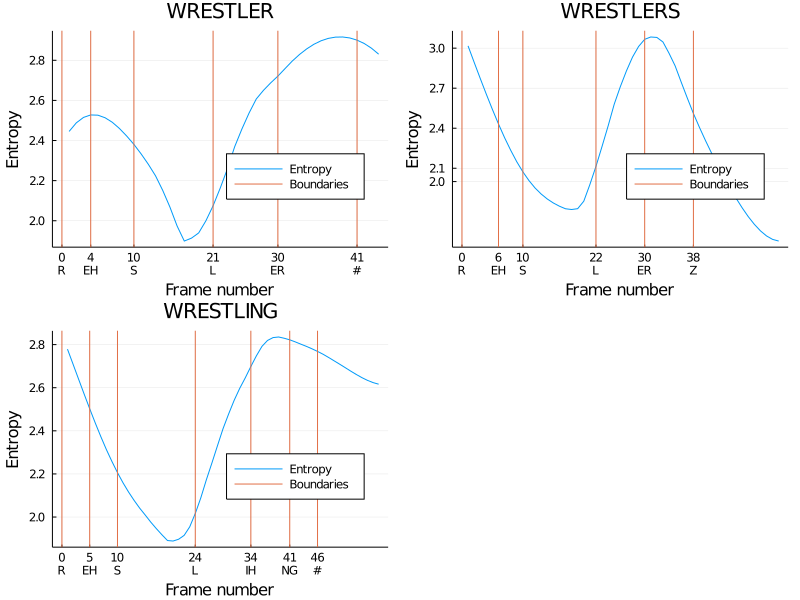

In [5]:
wrestler = entropyPlot("WRESTLER", model, legendLocation=:bottomright)
wrestlers = entropyPlot("WRESTLERS", model, legendLocation=:bottomright)
wrestling = entropyPlot("WRESTLING", model, legendLocation=:bottomright)

plot(wrestler, wrestlers, wrestling, size=[800, 600], layout=3)

At first blush, the decreasing entropy trend is not particularly salient, even with this loess smoothed curve. However, consider that coarticulatory cues may provide extra information about upcoming segments. We might expect then that the entropy will start to decrease about halfway through the segment preceding its uniqueness point. And in fact, this is what is observed in these visualizations.

* For *wrestler*, halfway between /ER/ and the silence or offset, the entropy begins decreasing
* For *wrestlers*, about a quarter of the way between /ER/ and /Z/, the entropy begins decreasing
* For *wrestling*, the entropy decreases until just a bit before [L], which might be expected due to the predictability of [L] after the [R EH S] sequence. Halfway between [IH] and [NG} a steady decrease is seen.

We might consider this evidence that the model has indeed learned some sort of temporal sequencing related to uniqueness points.

Let's consider another set of words, *walk*, *walked*, and *walkers*. In these data, *walk* becomes unique at the end of /K/, *walked* becomes unique at the beginning of /T/, and *walkers* becomes unique at the beginning of /ER/. If the previously observed pattern is consistent, however, we should expect to see changes in the entropy from about the midpoint of the unique segment.

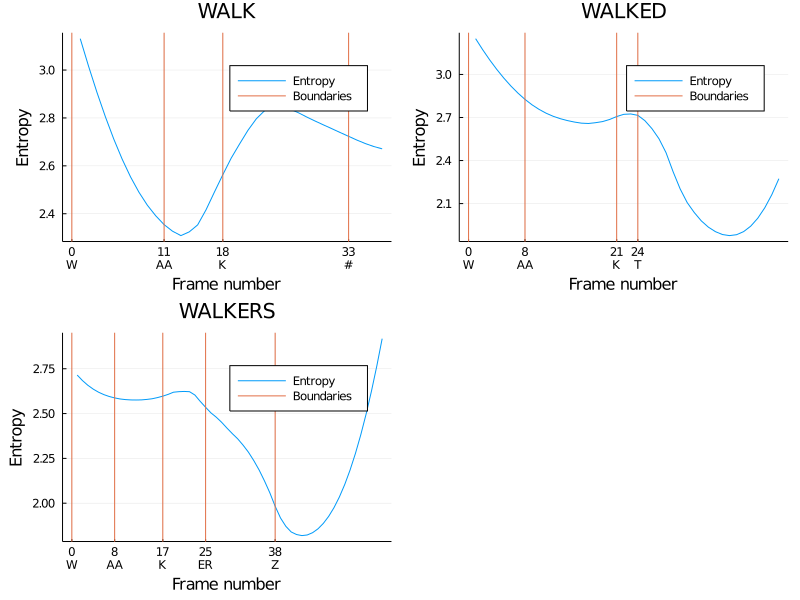

In [6]:
walk = entropyPlot("WALK", model, legendLocation=:topright)
walked = entropyPlot("WALKED", model, legendLocation=:topright)
walkers = entropyPlot("WALKERS", model, legendLocation=:topright)

plot(walk, walked, walkers, size=[800, 600], layout=3)

In fact, the predicted trend is observed for *walked* and *walkers*, but not *walk*.

* For *walk*, there is a more or less constant increase in entropy. This is suprising because [K] is certainly seems like it would be predictable following [W AA], yet the trend of increasing entropy is seen in all three words here, to varying degrees. Perhaps it is the case that the model is simply unsure with *walk* what the end result will be until after the [K]. As well, though, there is surely a pronounced period of silence after the [K], which the model may also not generally be expecting.

* For *walked*, the decrease in entropy starts around the time the [K] is about to start, and the decrease continues until word offset. The entropy begins to creep up again a while after the [T] has been encountered. It is possible that this is again due to what is surely a pronounced period of silence that the model would not necessarily be expecting.

* For *walkers*, the entropy generally falls until partway through /ER/, after which it begins to rise, only to fall after /Z/. This could be due to there having been some other word that had a similar sequencing as *walkers*. However, in this particular data set, there don't appear to be many or any candidates that could cause this sort of competition. If you inspect the audio file for *walkers*, there are some peculiar acoustic qualities to it. The speaker uses creaky voice throughout, and the vowel becomes devoiced toward the end of it. These acoustic qualities may contribute to /ER/ in this word being a poor exemplar of the overall /ER/ sound, so the model is less sure about the identity of the segment. The waveform and spectrogram are presented below.

![Waveform and spectrogram of *walkers*](walkers.png)

# Conclusion of analysis

The previous analysis gave some interesting results, suggesting that entropy may decrease in the general case once an acoustic signal uniquely identifies a word. Obviously, there are limitations to completely extending this to human perception generally:

* We only looked qualitatively at the results of two trios of words
* The neural network here was trained on one speaker
* There was only one exemplar of each word
* Words were presented in isolation
* Only 10,000 words were selected, and they were selected randomly (not by, say, frequency)
* The network does not reach human performance in phoneme identification
* Phonemes *per se* have a questionable relationship with the acoustic signal
* The network was not validated or evaluated on any other data sets, so we have no indication of its goodness of fit

Nevertheless, insofar as both human perception and an artificial neural networks perform discrimination, the network serves as **paltry** evidence for the provocative idea that it is possible that human perception encodes these temporal patterns before even recognizing word forms. If this observation were to hold across a variety of other items and we resolved the limitations listed above, word form recognition—and thus semantic activation—would be said to begin during the processing of the acoustic signal, and not strictly after some sort of processing into discrete and/or abstract units.

# Workshop conclusion

In this workshop, we covered a number of topics. Primary among these topics were the construction of neural networks and how they might be used as models of cognition. Deep learning is a field of academic inquiry in its own right, so we have barely even scratched the surface of what is possible using deep learning methods. Things to try going forward might be to look at some sort of output other than phonemes (or graphemes) and some layer types that might be easier to interpret, such as convolutional layers.

Coming away from this workshop, my hope is that you now better understand what decisions go into making a deep learning model and why a researcher might use one for cognitive modeling and not just computational problem solving. Additionally, I hope that I have provided enough terminology and references (particularly in the previous notebook) for those interested in further research that they can search for and find further resources.

# References

Balling, L. W., & Baayen, R. H. (2012). Probability and surprisal in auditory comprehension of morphologically complex words. *Cognition, 125*(1), 80–106. https://doi.org/10.1016/j.cognition.2012.06.003